In [7]:
# 1. Gỡ cài đặt các bản lỗi
!pip uninstall -y torch torchtext torchvision torchaudio

# 2. Cài đặt phiên bản ổn định và TƯƠNG THÍCH (PyTorch 2.3 >= 1.13 -> Đạt yêu cầu)
!pip install torch==2.3.0 torchtext==0.18.0 torchvision==0.18.0 torchaudio==2.3.0

# 3. Tải dữ liệu ngôn ngữ cho Spacy
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

  Using cached torch-2.3.0-cp312-cp312-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached torchtext-0.18.0-cp312-cp312-manylinux1_x86_64.whl.metadata (7.9 kB)
  Using cached torchvision-0.18.0-cp312-cp312-manylinux1_x86_64.whl.metadata (6.6 kB)
  Using cached torchaudio-2.3.0-cp312-cp312-manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using c

In [8]:
from torchtext.data.utils import get_tokenizer
en_tokenizer = get_tokenizer('spacy', 'en_core_web_sm')
de_tokenizer = get_tokenizer('spacy', 'fr_core_news_sm')

/usr/local/lib/python3.12/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [9]:
import sys
import torch
import torchtext

print(f"Phiên bản Python: {sys.version}")
print(f"Phiên bản PyTorch: {torch.__version__}")
print(f"Phiên bản TorchText: {torchtext.__version__}")

Phiên bản Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Phiên bản PyTorch: 2.3.0+cu121
Phiên bản TorchText: 0.18.0+cpu


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
import spacy
import random
import io
import os
import time

/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [11]:
# --- CẤU HÌNH THIẾT BỊ ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # ==========================================
# # 1. CẤU HÌNH & TOKENIZER
# # ==========================================
# # Tải và load mô hình ngôn ngữ Spacy
# try:
#     spacy_en = spacy.load("en_core_web_sm")
#     spacy_fr = spacy.load("fr_core_news_sm")
# except OSError:
#     print("Downloading spacy models...")
#     os.system("python -m spacy download en_core_web_sm")
#     os.system("python -m spacy download fr_core_news_sm")
#     spacy_en = spacy.load("en_core_web_sm")
#     spacy_fr = spacy.load("fr_core_news_sm")

# def tokenize_en(text):
#     """Tokenize tiếng Anh"""
#     return [tok.text for tok in spacy_en.tokenizer(text)]

# def tokenize_fr(text):
#     """Tokenize tiếng Pháp"""
#     return [tok.text for tok in spacy_fr.tokenizer(text)]

# # ==========================================
# # 2. HÀM ĐỌC DỮ LIỆU TỪ FILE (LOAD DATA)
# # ==========================================
# def load_data_to_list(filepath):
#     """
#     Đọc file văn bản theo dòng và trả về một list các câu (string).
#     Loại bỏ ký tự xuống dòng (\n) ở cuối mỗi câu.
#     """
#     if not os.path.exists(filepath):
#         raise FileNotFoundError(f"Không tìm thấy file: {filepath}")

#     with open(filepath, 'r', encoding='utf-8') as f:
#         # Đọc từng dòng, strip() để bỏ \n, và lưu vào list
#         data_list = [line.strip() for line in f]

#     return data_list

# # ==========================================
# # 3. THIẾT LẬP ĐƯỜNG DẪN & LOAD LIST
# # ==========================================
# # Thay đổi đường dẫn này trỏ đến thư mục chứa file của bạn
# data_dir = '/content/drive/MyDrive/Dataset'

# # Định nghĩa đường dẫn file
# train_en_path = os.path.join(data_dir, 'train.en')
# train_fr_path = os.path.join(data_dir, 'train.fr')
# val_en_path   = os.path.join(data_dir, 'val.en')
# val_fr_path   = os.path.join(data_dir, 'val.fr')
# # test_en_path  = os.path.join(data_dir, 'test.en')
# # test_fr_path  = os.path.join(data_dir, 'test.fr')

# print("Đang đọc dữ liệu từ file vào List...")
# # Load dữ liệu vào các List
# train_en_list = load_data_to_list(train_en_path)
# train_fr_list = load_data_to_list(train_fr_path)
# val_en_list   = load_data_to_list(val_en_path)
# val_fr_list   = load_data_to_list(val_fr_path)
# # test_en_list  = load_data_to_list(test_en_path)
# # test_fr_list  = load_data_to_list(test_fr_path)

# # Kiểm tra nhanh độ dài các list (Phải bằng nhau từng cặp)
# assert len(train_en_list) == len(train_fr_list), "Lỗi: Độ dài tập Train En-Fr không khớp!"
# assert len(val_en_list) == len(val_fr_list), "Lỗi: Độ dài tập Val En-Fr không khớp!"
# # assert len(test_en_list) == len(test_fr_list), "Lỗi: Độ dài tập Test En-Fr không khớp!"

# # print(f"Đã load xong! Train: {len(train_en_list)}, Val: {len(val_en_list)}, Test: {len(test_en_list)}")

# print(f"Đã load xong! Train: {len(train_en_list)}, Val: {len(val_en_list)}")

# # ==========================================
# # 4. TẠO DATASET TỪ LIST (CUSTOM DATASET)
# # ==========================================
# class TranslationListDataset(Dataset):
#     def __init__(self, src_list, trg_list):
#         self.src_data = src_list
#         self.trg_data = trg_list

#     def __len__(self):
#         return len(self.src_data)

#     def __getitem__(self, idx):
#         return self.src_data[idx], self.trg_data[idx]

# # Khởi tạo Dataset
# train_ds = TranslationListDataset(train_en_list, train_fr_list)
# val_ds   = TranslationListDataset(val_en_list, val_fr_list)
# # test_ds  = TranslationListDataset(test_en_list, test_fr_list)

# # ==========================================
# # 5. XÂY DỰNG VOCABULARY (TỪ ĐIỂN)
# # ==========================================
# SPECIAL_TOKENS = ['<unk>', '<pad>', '<sos>', '<eos>']
# # Các index tương ứng
# UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3

# def build_vocab_from_list(text_list, tokenizer):
#     """Xây dựng từ điển từ list các câu văn bản"""
#     def yield_tokens(data_iter):
#         for text in data_iter:
#             yield tokenizer(text)

#     vocab = build_vocab_from_iterator(
#         yield_tokens(text_list),
#         min_freq=2,
#         specials=SPECIAL_TOKENS,
#         max_tokens=10000 # Giới hạn 10.000 từ phổ biến nhất theo đề bài
#     )
#     vocab.set_default_index(UNK_IDX)
#     return vocab

# print("Đang xây dựng Vocabulary...")
# # Chỉ dùng tập Train để build vocab
# vocab_en = build_vocab_from_list(train_en_list, tokenize_en)
# vocab_fr = build_vocab_from_list(train_fr_list, tokenize_fr)

# print(f"Vocab En size: {len(vocab_en)}")
# print(f"Vocab Fr size: {len(vocab_fr)}")

# # ==========================================
# # 6. DATALOADER & COLLATE_FN
# # ==========================================
# def text_pipeline(text, vocab, tokenizer):
#     """Chuyển text -> List[int] (Token IDs)"""
#     return [SOS_IDX] + [vocab[token] for token in tokenizer(text)] + [EOS_IDX]

# def collate_fn(batch):
#     """
#     Hàm xử lý batch: Tokenize -> Padding -> Packing Sort
#     """
#     src_batch, trg_batch = [], []

#     for src_sample, trg_sample in batch:
#         src_batch.append(torch.tensor(text_pipeline(src_sample, vocab_en, tokenize_en)))
#         trg_batch.append(torch.tensor(text_pipeline(trg_sample, vocab_fr, tokenize_fr)))

#     # Lấy độ dài câu nguồn để sort (Yêu cầu bắt buộc cho pack_padded_sequence)
#     src_lens = [len(x) for x in src_batch]

#     # Sort batch theo độ dài giảm dần
#     zipped = sorted(zip(src_batch, trg_batch, src_lens), key=lambda x: x[2], reverse=True)
#     src_batch, trg_batch, src_lens = zip(*zipped)

#     # Padding (Thêm <pad> vào câu ngắn cho bằng câu dài nhất trong batch)
#     src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
#     trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)

#     return src_batch, trg_batch, torch.tensor(src_lens)

# # Tạo DataLoader
# BATCH_SIZE = 128 # Theo mục 6.1 (32-128)

# train_iterator = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
# valid_iterator = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
# # test_iterator  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# print("Hoàn tất chuẩn bị dữ liệu (Mục 6.1)!")

In [22]:
import os
import spacy
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence

# ==========================================
# 1. CẤU HÌNH & TOKENIZER
# ==========================================
# Tải và load mô hình ngôn ngữ Spacy
try:
    spacy_en = spacy.load("en_core_web_sm")
    spacy_fr = spacy.load("fr_core_news_sm")
except OSError:
    print("Downloading spacy models...")
    os.system("python -m spacy download en_core_web_sm")
    os.system("python -m spacy download fr_core_news_sm")
    spacy_en = spacy.load("en_core_web_sm")
    spacy_fr = spacy.load("fr_core_news_sm")

def tokenize_en(text):
    """Tokenize tiếng Anh"""
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_fr(text):
    """Tokenize tiếng Pháp"""
    return [tok.text for tok in spacy_fr.tokenizer(text)]

# ==========================================
# 2. HÀM ĐỌC DỮ LIỆU TỪ FILE (LOAD DATA)
# ==========================================
def load_data_to_list(filepath):
    """
    Đọc file văn bản theo dòng và trả về một list các câu (string).
    Loại bỏ ký tự xuống dòng (\n) ở cuối mỗi câu.
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Không tìm thấy file: {filepath}")

    with open(filepath, 'r', encoding='utf-8') as f:
        # Đọc từng dòng, strip() để bỏ \n, và lưu vào list
        data_list = [line.strip() for line in f]

    return data_list

# ==========================================
# 3. THIẾT LẬP ĐƯỜNG DẪN & LOAD LIST
# ==========================================
data_dir = '/content/drive/MyDrive/Dataset'

train_en_path = os.path.join(data_dir, 'train.en')
train_fr_path = os.path.join(data_dir, 'train.fr')
val_en_path   = os.path.join(data_dir, 'val.en')
val_fr_path   = os.path.join(data_dir, 'val.fr')
test_2016_flickr_en_path  = os.path.join(data_dir, 'test_2016_flickr.en')
test_2016_flickr_fr_path  = os.path.join(data_dir, 'test_2016_flickr.fr')
test_2017_flickr_en_path  = os.path.join(data_dir, 'test_2017_flickr.en')
test_2017_flickr_fr_path  = os.path.join(data_dir, 'test_2017_flickr.fr')
test_2018_flickr_en_path  = os.path.join(data_dir, 'test_2018_flickr.en')
test_2018_flickr_fr_path  = os.path.join(data_dir, 'test_2018_flickr.fr')
test_2017_mscoco_en_path  = os.path.join(data_dir, 'test_2017_mscoco.en')
test_2017_mscoco_fr_path  = os.path.join(data_dir, 'test_2017_mscoco.fr')

print("Đang đọc dữ liệu từ file vào List...")

# Load dữ liệu vào các List
train_en_list = load_data_to_list(train_en_path)
train_fr_list = load_data_to_list(train_fr_path)
val_en_list   = load_data_to_list(val_en_path)
val_fr_list   = load_data_to_list(val_fr_path)
test_2016_flickr_en_list  = load_data_to_list(test_2016_flickr_en_path)
test_2016_flickr_fr_list  = load_data_to_list(test_2016_flickr_fr_path)
test_2017_flickr_en_list  = load_data_to_list(test_2017_flickr_en_path)
test_2017_flickr_fr_list  = load_data_to_list(test_2017_flickr_fr_path)
test_2018_flickr_en_list  = load_data_to_list(test_2018_flickr_en_path)
test_2018_flickr_fr_list  = load_data_to_list(test_2018_flickr_fr_path)
test_2017_mscoco_en_list  = load_data_to_list(test_2017_mscoco_en_path)
test_2017_mscoco_fr_list  = load_data_to_list(test_2017_mscoco_fr_path)

# Kiểm tra nhanh độ dài

# In thông tin số lượng mẫu (Đúng định dạng yêu cầu)
print(f"Đã load xong! Train: {len(train_en_list)}, Val: {len(val_en_list)}")
print(f"Test: {len(test_2016_flickr_en_list)}, {len(test_2017_flickr_en_list)}, {len(test_2018_flickr_en_list)}, {len(test_2017_mscoco_en_list)}")
# ==========================================
# 4. TẠO DATASET TỪ LIST
# ==========================================
class TranslationListDataset(Dataset):
    def __init__(self, src_list, trg_list):
        self.src_data = src_list
        self.trg_data = trg_list
    def __len__(self): return len(self.src_data)
    def __getitem__(self, idx): return self.src_data[idx], self.trg_data[idx]

train_ds = TranslationListDataset(train_en_list, train_fr_list)
val_ds   = TranslationListDataset(val_en_list, val_fr_list)
test_ds  = TranslationListDataset(test_2017_flickr_en_list, test_2017_flickr_fr_list)

# ==========================================
# 5. XÂY DỰNG VOCABULARY
# ==========================================
SPECIAL_TOKENS = ['<unk>', '<pad>', '<sos>', '<eos>']
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3

def build_vocab_from_list(text_list, tokenizer):
    def yield_tokens(data_iter):
        for text in data_iter: yield tokenizer(text)

    vocab = build_vocab_from_iterator(
        yield_tokens(text_list), min_freq=2, specials=SPECIAL_TOKENS, max_tokens=10000
    )
    vocab.set_default_index(UNK_IDX)
    return vocab

print("Đang xây dựng Vocabulary...")
vocab_en = build_vocab_from_list(train_en_list, tokenize_en)
vocab_fr = build_vocab_from_list(train_fr_list, tokenize_fr)

# In thông tin vocab (Đúng định dạng yêu cầu)
print(f"Vocab En: {len(vocab_en)}, Vocab Fr: {len(vocab_fr)}")

# ==========================================
# 6. DATALOADER & COLLATE_FN
# ==========================================
def text_pipeline(text, vocab, tokenizer):
    return [SOS_IDX] + [vocab[token] for token in tokenizer(text)] + [EOS_IDX]

def collate_fn(batch):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(torch.tensor(text_pipeline(src_sample, vocab_en, tokenize_en)))
        trg_batch.append(torch.tensor(text_pipeline(trg_sample, vocab_fr, tokenize_fr)))

    src_lens = [len(x) for x in src_batch]
    zipped = sorted(zip(src_batch, trg_batch, src_lens), key=lambda x: x[2], reverse=True)
    src_batch, trg_batch, src_lens = zip(*zipped)

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    return src_batch, trg_batch, torch.tensor(src_lens)

BATCH_SIZE = 128
train_iterator = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_iterator = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_iterator  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print("Hoàn tất chuẩn bị dữ liệu (Train/Val/Test)!")

Đang đọc dữ liệu từ file vào List...
Đã load xong! Train: 29000, Val: 1014
Test: 1000, 1000, 1071, 461
Đang xây dựng Vocabulary...
Vocab En: 6191, Vocab Fr: 6555
Hoàn tất chuẩn bị dữ liệu (Train/Val/Test)!


In [23]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        # dropout được áp dụng giữa các layer LSTM (nếu n_layers > 1)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_len):
        # src: [src len, batch size]
        embedded = self.dropout(self.embedding(src))

        # Pack sequence: Tối ưu tính toán cho các câu có độ dài khác nhau
        # Lưu ý: src_len phải ở trên CPU
        packed_embedded = pack_padded_sequence(embedded, src_len.to('cpu'), enforce_sorted=True)

        packed_outputs, (hidden, cell) = self.rnn(packed_embedded)

        # Trả về hidden và cell state cuối cùng để làm context vector cho Decoder
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input: [batch size] (chỉ 1 token tại thời điểm t)
        input = input.unsqueeze(0) # -> [1, batch size]

        embedded = self.dropout(self.embedding(input))

        # Decoder chạy từng bước thời gian (time step)
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))

        # output: [1, batch size, hid dim] -> squeeze -> [batch size, hid dim]
        prediction = self.fc_out(output.squeeze(0))

        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        # src: [src len, batch size]
        # trg: [trg len, batch size]

        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # Tensor lưu kết quả [trg len, batch size, vocab size]
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # 1. Encoder: Nhận chuỗi nguồn -> Trả về Context Vector (hidden, cell)
        hidden, cell = self.encoder(src, src_len)

        # 2. Decoder: Bắt đầu với token đầu tiên của trg (thường là <sos>)
        input = trg[0, :]

        for t in range(1, trg_len):
            # Chạy decoder bước t
            output, hidden, cell = self.decoder(input, hidden, cell)

            # Lưu dự đoán
            outputs[t] = output

            # Teacher Forcing: Quyết định dùng token thực tế (trg) hay token dự đoán (top1) cho bước t+1
            top1 = output.argmax(1)
            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[t] if teacher_force else top1

        return outputs

# ==========================================
# KHỞI TẠO MÔ HÌNH & THAM SỐ (Theo hình ảnh yêu cầu)
# ==========================================

# Lấy kích thước từ điển từ bước trước (vocab_en, vocab_fr đã build ở phần 6.1)
INPUT_DIM = len(vocab_en)
OUTPUT_DIM = len(vocab_fr)

# Tham số khuyến nghị từ hình ảnh:
# Hidden size: 512
# Embedding dim: 256-512 (Chọn 256)
# Số layer: 2
# Dropout: 0.3-0.5 (Chọn 0.5)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

# Khởi tạo các module
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(enc, dec, device).to(device)

# Khởi tạo trọng số (Weight Initialization)
# Giúp mô hình hội tụ tốt hơn
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.uniform_(param.data, -0.08, 0.08)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

# In số lượng tham số để kiểm tra quy mô mô hình
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Mô hình đã khởi tạo thành công trên {device}')
print(f'Tổng số tham số khả huấn (Trainable parameters): {count_parameters(model):,}')

Mô hình đã khởi tạo thành công trên cuda
Tổng số tham số khả huấn (Trainable parameters): 13,982,107


In [16]:
save_dir = '/content/drive/MyDrive/Dataset'
checkpoint_path = os.path.join(save_dir, 'last_checkpoint.pth') # File lưu trạng thái để resume
best_model_path = os.path.join(save_dir, 'best_model.pth')     # File lưu model tốt nhất (nộp bài)

In [17]:
# ==========================================
# 6.3. HUẤN LUYỆN MÔ HÌNH (RESUME + AUTO-SAVE DRIVE)
# ==========================================

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# --- CÁC BIẾN QUẢN LÝ HUẤN LUYỆN ---
N_EPOCHS = 20
CLIP = 1
start_epoch = 0
best_valid_loss = float('inf')
patience_counter = 0
PATIENCE = 3
train_losses = []
valid_losses = []

# --- LOGIC TỰ ĐỘNG LOAD CHECKPOINT (RESUME) ---
if os.path.exists(checkpoint_path):
    print(f"--> [INFO] Phát hiện checkpoint tại {checkpoint_path}")
    print("--> Đang tải lại trạng thái để tiếp tục huấn luyện...")

    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1 # Bắt đầu từ epoch tiếp theo
    best_valid_loss = checkpoint['best_valid_loss']
    train_losses = checkpoint.get('train_losses', [])
    valid_losses = checkpoint.get('valid_losses', [])

    print(f"--> Đã khôi phục thành công! Sẽ tiếp tục từ Epoch {start_epoch + 1}")
else:
    print("--> Không tìm thấy checkpoint cũ. Bắt đầu huấn luyện từ đầu.")

# --- CẤU HÌNH LƯU ĐỊNH KỲ ---
CHECKPOINT_INTERVAL = 15 * 60  # 15 phút
last_save_time = time.time()

# Hàm train/eval (giữ nguyên logic)
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, (src, trg, src_len) in enumerate(iterator):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, src_len, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (src, trg, src_len) in enumerate(iterator):
            src, trg = src.to(device), trg.to(device)
            output = model(src, src_len, trg, 0)
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# --- VÒNG LẶP HUẤN LUYỆN ---
print(f"\nBắt đầu Training từ Epoch {start_epoch + 1} đến {N_EPOCHS}...")

for epoch in range(start_epoch, N_EPOCHS):
    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    print(f'Epoch: {epoch+1:02} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')

    # 1. Lưu Best Model (Để nộp bài)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), best_model_path) # Lưu vào Drive
        print(f"\t--> Đã lưu Best Model mới (Val Loss: {valid_loss:.3f})")
        patience_counter = 0
    else:
        patience_counter += 1

    # 2. Lưu Checkpoint (Để resume) - Lưu mỗi epoch HOẶC mỗi 15p
    current_time = time.time()
    if (current_time - last_save_time > CHECKPOINT_INTERVAL) or (epoch == N_EPOCHS - 1):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_valid_loss': best_valid_loss,
            'train_losses': train_losses,
            'valid_losses': valid_losses
        }, checkpoint_path)
        print(f"\t--> [SAFE] Đã lưu Checkpoint vào Drive.")
        last_save_time = current_time

    # Early Stopping
    if patience_counter >= PATIENCE:
        print("Early stopping triggered!")
        break

print("Huấn luyện hoàn tất!")

--> Không tìm thấy checkpoint cũ. Bắt đầu huấn luyện từ đầu.

Bắt đầu Training từ Epoch 1 đến 20...
Epoch: 01 | Time: 1m 0s
	Train Loss: 4.754 | Val. Loss: 4.635
	--> Đã lưu Best Model mới (Val Loss: 4.635)
Epoch: 02 | Time: 1m 0s
	Train Loss: 3.944 | Val. Loss: 4.406
	--> Đã lưu Best Model mới (Val Loss: 4.406)
Epoch: 03 | Time: 1m 0s
	Train Loss: 3.491 | Val. Loss: 4.152
	--> Đã lưu Best Model mới (Val Loss: 4.152)
Epoch: 04 | Time: 1m 0s
	Train Loss: 3.151 | Val. Loss: 3.967
	--> Đã lưu Best Model mới (Val Loss: 3.967)
Epoch: 05 | Time: 1m 10s
	Train Loss: 2.861 | Val. Loss: 3.773
	--> Đã lưu Best Model mới (Val Loss: 3.773)
Epoch: 06 | Time: 1m 1s
	Train Loss: 2.605 | Val. Loss: 3.591
	--> Đã lưu Best Model mới (Val Loss: 3.591)
Epoch: 07 | Time: 1m 2s
	Train Loss: 2.402 | Val. Loss: 3.475
	--> Đã lưu Best Model mới (Val Loss: 3.475)
Epoch: 08 | Time: 1m 2s
	Train Loss: 2.208 | Val. Loss: 3.446
	--> Đã lưu Best Model mới (Val Loss: 3.446)
Epoch: 09 | Time: 1m 0s
	Train Loss: 2.055 

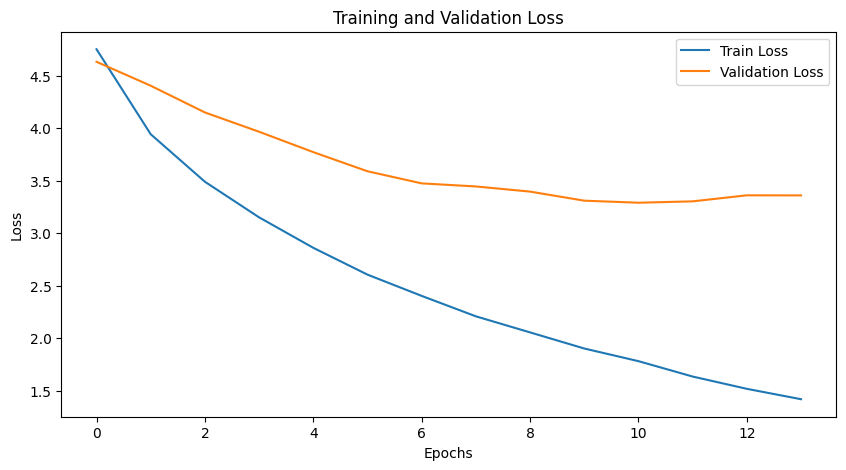

In [18]:
# ==========================================
# VẼ BIỂU ĐỒ LOSS (YÊU CẦU MỤC 11)
# ==========================================
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [20]:
# ==========================================
# 6.4. DỰ ĐOÁN (INFERENCE)
# ==========================================

def translate(sentence: str):
    # Load model tốt nhất
    model.load_state_dict(torch.load('/content/drive/MyDrive/Dataset/best_model.pth'))
    model.eval()

    # 1. Tokenize & Numericalize
    tokens = tokenize_en(sentence)
    tokens = [vocab_en['<sos>']] + [vocab_en[token] for token in tokens] + [vocab_en['<eos>']]
    src_tensor = torch.LongTensor(tokens).unsqueeze(1).to(device) # [src_len, 1]
    src_len = torch.LongTensor([len(tokens)])

    # 2. Encoder
    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor, src_len)

    # 3. Decoder (Greedy Decoding)
    trg_indexes = [vocab_fr['<sos>']]
    max_len = 50 # Độ dài tối đa 50 (Yêu cầu đề bài)

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == vocab_fr['<eos>']:
            break

    # 4. Convert ids -> text
    trg_tokens = [vocab_fr.lookup_token(i) for i in trg_indexes]

    # Loại bỏ <sos> và <eos>
    return " ".join(trg_tokens[1:-1])

# Test thử hàm translate
sample_sentence = "A group of men are loading cotton onto a big car"
print(f"\nOriginal: {sample_sentence}")
# Lưu ý: Hàm này chỉ chạy được khi đã train xong và có file best_model.pth
print(f"Translated: {translate(sample_sentence)}")


Original: A group of men are loading cotton onto a big car
Translated: Un groupe d' hommes font une une une voiture .


In [24]:
import torch
from nltk.translate.bleu_score import sentence_bleu

# ==========================================
# 6.5. ĐÁNH GIÁ (EVALUATION & BLEU SCORE) - ĐA BỘ TEST
# ==========================================

# 1. Hàm dịch câu
def translate_sentence(sentence, model, device, max_len=50):
    model.eval()

    # Tokenize Source
    if isinstance(sentence, str):
        tokens = [tok.text for tok in spacy_en.tokenizer(sentence)]
    else:
        tokens = [token for token in sentence]

    # Thêm <sos>, <eos> và chuyển thành tensor
    tokens = [vocab_en['<sos>']] + [vocab_en[token] for token in tokens] + [vocab_en['<eos>']]
    src_tensor = torch.LongTensor(tokens).unsqueeze(1).to(device)
    src_len = torch.LongTensor([len(tokens)])

    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor, src_len)

    trg_indexes = [vocab_fr['<sos>']]

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == vocab_fr['<eos>']:
            break

    # Convert id -> Token
    trg_tokens = [vocab_fr.lookup_token(i) for i in trg_indexes]

    # Trả về list token (bỏ <sos>)
    return trg_tokens[1:]

# 2. Hàm đánh giá một bộ dữ liệu cụ thể (có giới hạn số mẫu)
def evaluate_single_set(model, dataset_name, src_list, trg_list, device, limit=2000):
    """
    Hàm này tính BLEU cho 1 cặp danh sách (src, trg) với giới hạn số lượng mẫu.
    """
    bleu_scores = []

    # Cắt dữ liệu theo limit (nếu limit = None thì lấy hết)
    if limit:
        src_eval = src_list[:limit]
        trg_eval = trg_list[:limit]
    else:
        src_eval = src_list
        trg_eval = trg_list

    print(f"--> Đang đánh giá bộ: {dataset_name} (Số mẫu: {len(src_eval)})")

    for i in range(len(src_eval)):
        src = src_eval[i]
        trg = trg_eval[i]

        # Dịch
        pred_tokens = translate_sentence(src, model, device)

        # Chuẩn bị Target (Reference)
        trg_tokens = [tok.text for tok in spacy_fr.tokenizer(trg)]

        # Loại bỏ <eos> ở dự đoán nếu có
        if pred_tokens and pred_tokens[-1] == '<eos>':
            pred_tokens = pred_tokens[:-1]

        # Tính BLEU score cho câu hiện tại
        score = sentence_bleu([trg_tokens], pred_tokens)
        bleu_scores.append(score)

        # (Tùy chọn) In tiến độ mỗi 500 câu để đỡ sốt ruột
        if (i + 1) % 500 == 0:
            print(f"    ...Đã xử lý {i + 1} câu.")

    # Tính trung bình BLEU của bộ này
    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
    print(f"--> Kết quả {dataset_name}: {avg_bleu*100:.2f} BLEU")
    return avg_bleu

# 3. Hàm chạy toàn bộ quy trình đánh giá
def run_full_evaluation(model, device):
    # Load model tốt nhất MỘT LẦN duy nhất
    print(f"--> Đang tải model tốt nhất từ {best_model_path}...")
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()

    # Định nghĩa danh sách các bộ test cần đánh giá
    # Cấu trúc: "Tên hiển thị": (List Tiếng Anh, List Tiếng Pháp)
    test_datasets = {
        "Flickr 2016": (test_2016_flickr_en_list, test_2016_flickr_fr_list),
        "Flickr 2017": (test_2017_flickr_en_list, test_2017_flickr_fr_list),
        "Flickr 2018": (test_2018_flickr_en_list, test_2018_flickr_fr_list),
        "MSCOCO 2017": (test_2017_mscoco_en_list, test_2017_mscoco_fr_list)
    }

    all_scores = []

    print(f"\n{'='*50}")
    print(f"BẮT ĐẦU ĐÁNH GIÁ (LIMIT = 2000 MẪU/BỘ)")
    print(f"{'='*50}")

    for name, (src_data, trg_data) in test_datasets.items():
        # Gọi hàm đánh giá từng bộ
        score = evaluate_single_set(model, name, src_data, trg_data, device, limit=2000)
        all_scores.append(score)
        print("-" * 30)

    # Tính trung bình cộng của tất cả các bộ
    final_avg_bleu = sum(all_scores) / len(all_scores) if all_scores else 0

    print(f"\n{'='*50}")
    print(f"TỔNG HỢP KẾT QUẢ CUỐI CÙNG")
    print(f"{'='*50}")
    for i, name in enumerate(test_datasets.keys()):
        print(f"{name:<15}: {all_scores[i]*100:.2f}")

    print("-" * 30)
    print(f"TRUNG BÌNH CHUNG : {final_avg_bleu*100:.2f}")
    print(f"{'='*50}")

# ==========================================
# THỰC THI (Chạy ngay sau khi load data xong)
# ==========================================

# Đảm bảo bạn đã có biến 'model', 'device', 'best_model_path'
# và các list dữ liệu (test_2016_flickr_en_list, ...) từ bước trước.

run_full_evaluation(model, device)

--> Đang tải model tốt nhất từ /content/drive/MyDrive/Dataset/best_model.pth...

BẮT ĐẦU ĐÁNH GIÁ (LIMIT = 2000 MẪU/BỘ)
--> Đang đánh giá bộ: Flickr 2016 (Số mẫu: 1000)
    ...Đã xử lý 500 câu.
    ...Đã xử lý 1000 câu.
--> Kết quả Flickr 2016: 28.22 BLEU
------------------------------
--> Đang đánh giá bộ: Flickr 2017 (Số mẫu: 1000)
    ...Đã xử lý 500 câu.
    ...Đã xử lý 1000 câu.
--> Kết quả Flickr 2017: 18.83 BLEU
------------------------------
--> Đang đánh giá bộ: Flickr 2018 (Số mẫu: 1071)
    ...Đã xử lý 500 câu.
    ...Đã xử lý 1000 câu.
--> Kết quả Flickr 2018: 10.55 BLEU
------------------------------
--> Đang đánh giá bộ: MSCOCO 2017 (Số mẫu: 461)
--> Kết quả MSCOCO 2017: 10.63 BLEU
------------------------------

TỔNG HỢP KẾT QUẢ CUỐI CÙNG
Flickr 2016    : 28.22
Flickr 2017    : 18.83
Flickr 2018    : 10.55
MSCOCO 2017    : 10.63
------------------------------
TRUNG BÌNH CHUNG : 17.06
